#  Evaluate the value of travel time for transportation in Seoul metropolitan areas

In [4]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import rcParams
from xlogit import MultinomialLogit
from xlogit.utils import wide_to_long
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

rcParams['font.family'] = 'Malgun Gothic' # print Korea language
warnings.filterwarnings('ignore') # ignore the warning sign


### Load files

* `RP_data`: revealed-preferenced survey data conducted in Seoul metropolitan areas, South Korea, 2021
* `dong_data`:information of South Korea's administrative dong

In [5]:
# load data
RP_data =  pd.read_excel('data_VOT/mode_choice_data_230623.xlsx', index_col = 0)
dong_data =  pd.read_excel('data_VOT/info_admin_230709.xlsx', index_col = 0)

In [6]:
RP_data.head()

,fid,O_code,O_si,O_admin,O_station,D_code,D_si,D_admin,D_station,purpose,...,dist_subway,invehicletime_subway,outvehicletime_subway,accesstime_subway,waittime_subway,egresstime_subway,transfertime_subway,totaltime_subway,trans_subway,totalcost_subway
panel,,,,,,,,,,,,,,,,,,,,,
10070,207,3114055,31,1,1,3117056,31,1,1,1,...,32686,48.300000,34.283333,4.900000,21.966667,3.650000,3.766667,82.583333,2,1750.0
10070,214,3117056,31,1,1,3114055,31,1,1,2,...,32833,47.266667,33.950000,8.766667,16.850000,4.900000,3.433333,81.216667,2,1950.0
10079,426,1122053,11,1,1,1121078,11,1,1,3,...,7921,12.000000,16.550000,9.350000,0.000000,7.200000,0.000000,28.550000,0,1250.0
10079,504,1121078,11,1,1,1122053,11,1,1,4,...,7517,12.000000,9.833333,7.200000,0.000000,2.633333,0.000000,21.833333,0,1250.0
10085,256,2308053,23,1,1,2308058,23,1,1,1,...,5165,7.000000,13.366667,8.416667,0.000000,4.950000,0.000000,20.366667,0,1250.0


In [7]:
dong_data.head()

,si,gu,region,dong,code_region,code_dong
index,,,,,,
0,서울특별시,종로구,청운효자동,청운효자동,1101072,1111051500
1,서울특별시,종로구,사직동,사직동,1101053,1111053000
2,서울특별시,종로구,삼청동,삼청동,1101054,1111054000
3,서울특별시,종로구,부암동,부암동,1101055,1111055000
4,서울특별시,종로구,평창동,평창동,1101056,1111056000


### Define functions of Log-likelihood Test and Summary 

```python
def DetectOutliers(df, columns):
    return df

def LikelihoodRatioTest(model1_logll, model2_logll, model1_params, model2_params):
    return p-value

def SummarizeModel(model):
    return dict_value_of_time, dict_model

def SummarizeModel_in(model):
    return dict_value_of_time, dict_model

def SummarizeModel_in_out(model):
    return dict_value_of_time, dict_model

def SummarizeModel_pri_pub(model):
    return dict_value_of_time, dict_model

def McFadden(df):
    return mcfadden 
```

* `DetectOutliers`:  remove the outliers based on column and print the dataframe
* `LikelihoodRatioTest`: print the model's fitness using the loglikelihood ratio test
* `SummarizeModel`: print the results of a proposed base model with the time term considered as the total time
* `SummarizeModel_in`: print the results of a developed model with the time term only considered as the in-vehicle time
* `SummarizeModel_in_out`: print the results of a developed model with the time term considered as the in-vehicle and out-vehicle time
* `SummarizeModel_pri_pub`: print the results of a revised model with time term constructed for private and public transportation
* `McFadden`: print the adjusted-R square metric

In [8]:
def DetectOutliers(df, columns):
    q1 = df[columns].quantile(0.25)
    q3 = df[columns].quantile(0.75)
    iqr = q3 - q1
    boundary = 1.5 * iqr
    index1 = df[df[columns] > q3 + boundary].index.tolist()
    index2 = df[df[columns] < q1 - boundary].index.tolist()
    list_index = index1 + index2
    df2 = df.drop(list_index, axis = 0)
    return df2

def LikelihoodRatioTest(model1_logll, model2_logll, model1_params, model2_params):
    LikelihoodRatio = - 2 * (model1_logll-model2_logll)
    p_value = chi2.sf(LikelihoodRatio, abs(model1_params - model2_params))
    print('p-value: %.30f'.format(p_value))
    return p_value
    
def SummarizeModel(model):
    value_of_time_auto = (model.coeff_[model.coeff_names == 'totaltime_auto'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_taxi = (model.coeff_[model.coeff_names == 'totaltime_taxi'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_bus = (model.coeff_[model.coeff_names == 'totaltime_bus'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_subway = (model.coeff_[model.coeff_names == 'totaltime_subway'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])

    dict_value_of_time = {
        'value_of_time_auto' : value_of_time_auto,
        'value_of_time_taxi' : value_of_time_taxi,
        'value_of_time_bus' : value_of_time_bus,
        'value_of_time_subway' : value_of_time_subway
    }
    
    dict_model = {
        'aic' : [model.aic],
        'bic' : [model.bic],
        'loglikelihood' : [model.loglikelihood],
        'params' : [len(model.coeff_)]
    }
    
    return dict_value_of_time, dict_model

def SummarizeModel_in(model):
    value_of_time_auto = (model.coeff_[model.coeff_names == 'invehicletime_auto'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_taxi = (model.coeff_[model.coeff_names == 'invehicletime_taxi'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_bus = (model.coeff_[model.coeff_names == 'invehicletime_bus'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_subway = (model.coeff_[model.coeff_names == 'invehicletime_subway'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
      
    dict_value_of_time = {
        'value_of_time_auto' : value_of_time_auto,
        'value_of_time_taxi' : value_of_time_taxi,
        'value_of_time_bus' : value_of_time_bus,
        'value_of_time_subway' : value_of_time_subway,
    }
    
    dict_model = {
        'aic' : [model.aic],
        'bic' : [model.bic],
        'loglikelihood' : [model.loglikelihood],
        'params' : [len(model.coeff_)]
    }
    
    return dict_value_of_time, dict_model


def SummarizeModel_in_out(model):
    value_of_time_auto = (model.coeff_[model.coeff_names == 'invehicletime_auto'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_taxi = (model.coeff_[model.coeff_names == 'invehicletime_taxi'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_bus = (model.coeff_[model.coeff_names == 'invehicletime_bus'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_subway = (model.coeff_[model.coeff_names == 'invehicletime_subway'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_outvehicletime = (model.coeff_[model.coeff_names == 'outvehicletime'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    
    dict_value_of_time = {
        'value_of_time_auto' : value_of_time_auto,
        'value_of_time_taxi' : value_of_time_taxi,
        'value_of_time_bus' : value_of_time_bus,
        'value_of_time_subway' : value_of_time_subway,
        'value_of_outvehicletime': value_of_outvehicletime
    }
    
    dict_model = {
        'aic' : [model.aic],
        'bic' : [model.bic],
        'loglikelihood' : [model.loglikelihood],
        'params' : [len(model.coeff_)]
    }
    
    return dict_value_of_time, dict_model

def SummarizeModel_pri_pub(model):
    value_of_time_private = (model.coeff_[model.coeff_names == 'totaltime_private'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
    value_of_time_public = (model.coeff_[model.coeff_names == 'totaltime_public'] * 60000) / (model.coeff_[model.coeff_names == 'totalcost'])
  
    dict_value_of_time = {
        'value_of_time_private' : value_of_time_private,
        'value_of_time_public' : value_of_time_public
    }
    
    dict_model = {
        'aic' : [model.aic],
        'bic' : [model.bic],
        'loglikelihood' : [model.loglikelihood],
        'params' : [len(model.coeff_)]
    }
    
    return dict_value_of_time, dict_model

def McFadden(df):
    y = df['choice']
    mu_null = np.sum(y) / len(y)
    y_null = np.ones_like(y) * mu_null
    dev0 = log_loss(y, y_null, normalize = False)
    mcfadden = 1 - (model.loglikelihood * -1 / dev0)
    print('McFadden R square : ', mcfadden)
    return mcfadden 

def SortModelbyPurpose(list_models, purpose):
    df = pd.DataFrame()
    for index, name in enumerate(list_models):
        df1 = list_models[name].loc[purpose, :]
        df = pd.concat([df, df1], ignore_index = True, axis = 1) 
    df.columns = list(list_models.keys())
    df = df.transpose()
    return df

###  Drop the duplicated and multimodal data

1. Remove the data where buses and subways have the same route
2. Remove the data that the traveler selected multi modal consisting of the bus and subway mode  

In [9]:
df = RP_data

print('Number of data before the removal task:', len(df))
print('Number of the duplicated data to be deleted:', len(df[df['duplication'] == 1]))
print('Number of the multimoal data to be deleted:', len(df[df['choice'] == 5]))

# Remove the duplicated and multimodal data
df = df[df['duplication'] == 0]
df = df[df['choice'] != 5] 

print('Number of data after the removal task:', len(df))

Number of data before the removal task: 91834
Number of the duplicated data to be deleted: 9662
Number of the multimoal data to be deleted: 6697
Number of data after the removal task: 75502


### Classify RP data by travel purpose
#### Before classification (categorical detail data) 
 * 출근 1
 * 귀가 2
 * 업무 3
 * 여가/운동/관광/레저 4
 * 친지방문 5 
 * 병원진료 6
 * 식사 7
 * 쇼핑, 음식포장 8
 * 귀사 9
 * 기타 10
 * 등교 11
 * 학원 12
 
#### After classification by travel purpose
 (1) 전체 통행: 1 ~ 12 
 
 (2) 출근 통행: 1 (출근)
 
 (3) 업무 통행: 3 (업무), 9 (귀사)
 
 (4) 비업무 통행: 1 (출근), 2 (귀가), 6 (병원진료), 10 (기타), 11 (등교), 12 (학원),  4 (여가), 5 (친지방문), 7 (식사), 8 (쇼핑)
 
 (5) 여가 통행: 4 (여가), 5 (친지방문), 7 (식사), 8 (쇼핑)

In [10]:
commute      = [1]
business     = [3, 9]
non_business = [1, 2, 6, 10, 11, 12, 4, 5, 7, 8]
leisure      = [4, 5, 7, 8]

df_all = df
df_all['choice'] = df_all['choice'].map({1:'auto', 2:'taxi', 3:'bus', 4:'subway'})
df_commute = df_all[(df_all['purpose'].isin(commute))]
df_business = df_all[(df_all['purpose'].isin(business))]
df_non_business = df_all[(df_all['purpose'].isin(non_business))]
df_leisure = df_all[(df_all['purpose'].isin(leisure))]

print('Trips by modes for all purpose: ', str(df_all['choice'].value_counts()))
print('Modal share for all purpose:', str(df_all['choice'].value_counts() * 100 / len(df_all)))
print('Trips by modes for commute purpose:', str(df_commute['choice'].value_counts()))
print('Modal share for commute purpose:',str(df_commute['choice'].value_counts() * 100 / len(df_commute)))
print('Trips by modes for business purpose:', str(df_business['choice'].value_counts()))
print('Modal share for business purpose:', str(df_business['choice'].value_counts() * 100 / len(df_business)))
print('Trips by modes for non-business purpose:', str(df_non_business['choice'].value_counts()))
print('Modal share for non-business purpose:', str(df_non_business['choice'].value_counts() * 100 / len(df_non_business)))
print('Trips by modes for leisure purpose:', str(df_leisure['choice'].value_counts()))
print('Modal share for for leisure purpose:',str(df_leisure['choice'].value_counts() * 100 / len(df_leisure)))

Trips by modes for all purpose:  auto      49095
subway    13362
bus       11322
taxi       1723
Name: choice, dtype: int64
Modal share for all purpose: auto      65.024768
subway    17.697544
bus       14.995629
taxi       2.282059
Name: choice, dtype: float64
Trips by modes for commute purpose: auto      11031
subway     3951
bus        2686
taxi        195
Name: choice, dtype: int64
Modal share for commute purpose: auto      61.753345
subway    22.118345
bus       15.036668
taxi       1.091642
Name: choice, dtype: float64
Trips by modes for business purpose: auto      5065
subway     892
bus        569
taxi       228
Name: choice, dtype: int64
Modal share for business purpose: auto      74.992597
subway    13.206988
bus        8.424637
taxi       3.375777
Name: choice, dtype: float64
Trips by modes for non-business purpose: auto      44030
subway    12470
bus       10753
taxi       1495
Name: choice, dtype: int64
Modal share for non-business purpose: auto      64.045500
subway    18

### Convert wide to long format data to fit the multinomial logit model 

This steps are follows as

1. Add columns such as `id` and `waittime_taxi`
2. Convert wide to long format data
3. Scale the `totalcost`
4. Make columns of ratio of various out-vehicle times to total time such as `ratio_outvehicletime`, `ratio_accesstime`, `ratio_waittime`, `ratio_egresstime`, `ratio_transfertime`.


In [11]:
# Add some columns
df['id'] = np.arange(len(df))
df['waittime_taxi'] = 5

# Convert wide to long
df = wide_to_long(df, id_col = 'id', alt_name = 'alt', sep = '_',
                        alt_list=['auto', 'taxi', 'bus', 'subway'], empty_val = 0,
                        varying = ['dist', 'totaltime', 'invehicletime', 'outvehicletime', 'accesstime', 'waittime', 'egresstime', 'transfertime',
                                   'totalcost','trans'])

# Scale the total cost
df['totalcost'] = df['totalcost'] / 1000 # Unit: 1000KRW
df['dist'] = df['dist'] / 1000 # Unit: km

# Make some columns of ratio of various out vehicle times to total time
df['ratio_outvehicletime'] = df['outvehicletime'] / df['totaltime']
df['ratio_accesstime'] = df['accesstime'] / df['totaltime']
df['ratio_waittime'] = df['waittime'] / df['totaltime']
df['ratio_egresstime'] = df['egresstime'] / df['totaltime']
df['ratio_transfertime'] = df['transfertime'] / df['totaltime']

### Visualize the data


* Scatter map for travel time and cost
* Figure of trip time and distance distribution

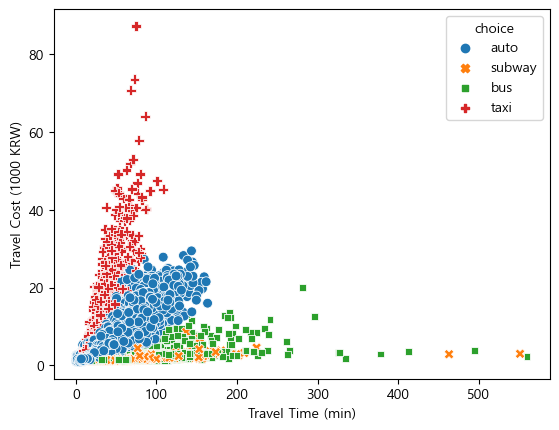

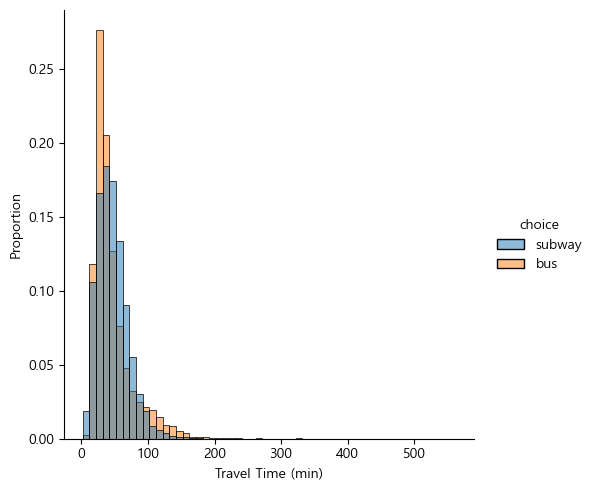

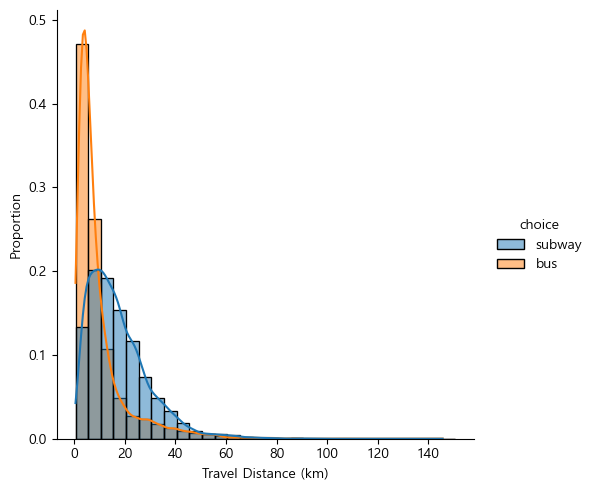

In [12]:
# Select choice 
df2 = df[df['alt'] == df['choice']]
df_public = df2[df2['choice'].isin(['bus','subway'])]
df_public['totalcost'] = df_public['totalcost'] * 1000 

g1 = sns.scatterplot(x='totaltime', 
                y='totalcost', 
                hue='choice',   # different colors by group
                style='choice', # different shapes by group
                s=50,           # marker size
                data=df2)
g1.set(xlabel='Travel Time (min)', ylabel= 'Travel Cost (1000 KRW)')

g2=sns.displot(x='totaltime', 
            hue='choice', 
            stat='proportion',
            common_norm=False, 
            binwidth=10,
            data=df_public)
g2.set_axis_labels("Travel Time (min)", "Proportion")

g3=sns.displot(x='dist',
            hue='choice',
            stat='proportion',
            kde=True,
            common_norm=False,
            binwidth=5,
            data=df_public)
g3.set_axis_labels("Travel Distance (km)", "Proportion")

plt.show()

[Text(0.5, 0, 'Travel Time (min)'), Text(0, 0.5, 'Proportion')]

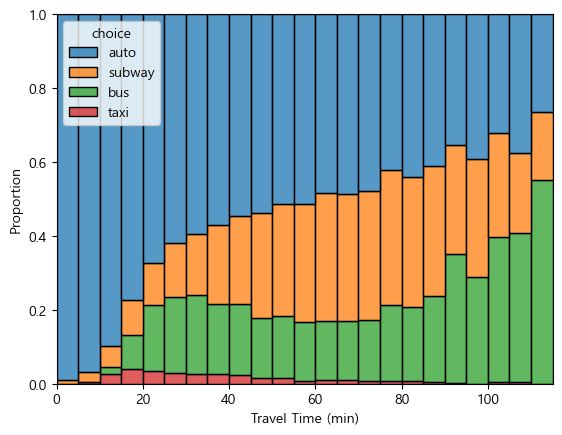

In [13]:
g4=sns.histplot(x="totaltime",
            hue="choice",
            multiple="fill",
            stat="proportion",
            bins=range(0,120,5),
            data=df2)
g4.set(xlabel='Travel Time (min)', ylabel="Proportion")

[Text(0.5, 0, 'Travel Distance (km)'), Text(0, 0.5, 'Proportion')]

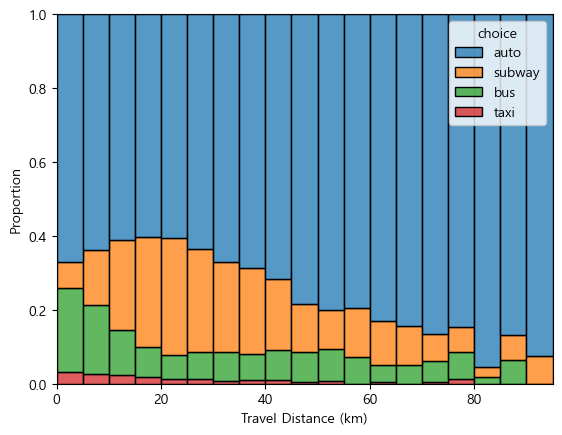

In [14]:
g5=sns.histplot(x="dist",
            hue="choice",
            multiple="fill",
            stat="proportion",
            bins=range(0,100,5),
            data=df2)
g5.set(xlabel='Travel Distance (km)', ylabel="Proportion")

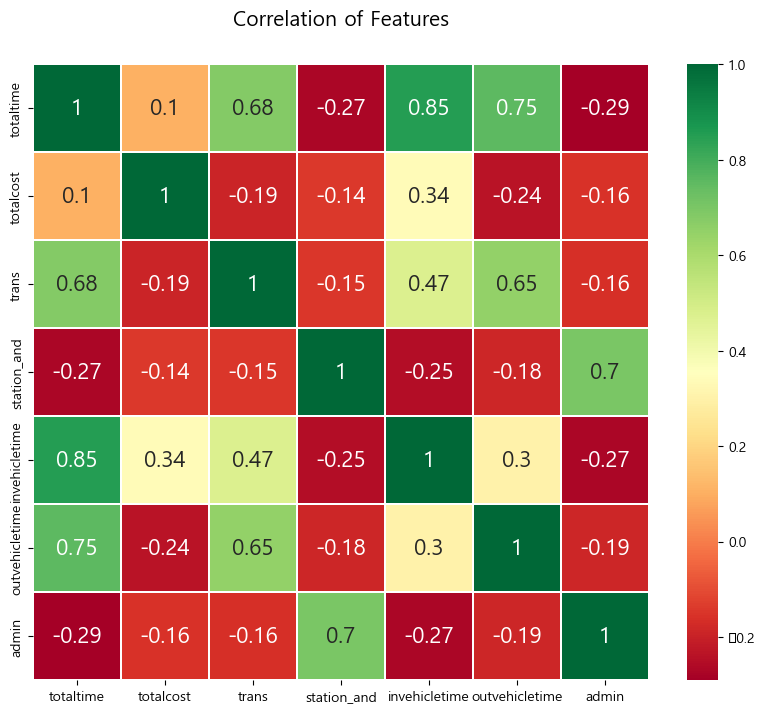

In [16]:
df_corr = df[['totaltime','totalcost','trans', 'station_and', 'invehicletime','outvehicletime','admin']]
corrmat = df_corr.astype(float).corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation of Features', y = 1.05, size = 15)
sns.heatmap(corrmat, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = 'RdYlGn', linecolor = 'white', annot = True, annot_kws = {'size' : 16})

plt.show()

In [17]:
# Classify the data by travel purpose
df_all_purpose = df
df_commute_purpose = df[(df['purpose'].isin(commute))]
df_business_purpose = df[(df['purpose'].isin(business))]
df_non_business_purpose = df[(df['purpose'].isin(non_business))]
df_leisure_purpose = df[(df['purpose'].isin(leisure))]

dict_df = {
    'all' : df_all_purpose, 
    'commute' : df_commute_purpose, 
    'business' : df_business_purpose, 
    'non_business' : df_non_business_purpose, 
    'leisure' : df_leisure_purpose
}

### Propose mode choice models that separate transportation into private and public modes

We proposed the four models for the private (e.g., auto, taxi) and public transportation modes (e.g., bus, subway) that are generated by various combinations of different explanatory variables manipulated in this research, such as the time, cost, number of transfer, and regional characteristics.

The written code is divided into two parts: model description and results

1. Model Description:
    The travel purposes for classification, explanatory variables, and utility functions of each mode are described.
 
2. Result:
    The value of time (VOT) for each mode and model's performance metrics such as aic, bic, and, log-likelihood value are presented.


####  Mode Choice Model Ver. 1 Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$ 
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_1 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_3 TT_\textrm{bus} + \beta_2 TC_\textrm{bus}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_3 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} $
* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [18]:
def MultinomialLogitModel1(df):
    print('수단 선택 확률 분포 (%):\n', str(df['choice'].value_counts() * 100 / len(df)))
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_private'] = df['totaltime'] * ((df['alt'] == 'auto') | (df['alt'] == 'taxi'))
    df['totaltime_public'] = df['totaltime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))

    varnames = ['asc_taxi', 'asc_bus', 'asc_subway',# Alternative Specific Constant
            'totalcost',                            # Generic Variable
            'totaltime_private','totaltime_public'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_private', 'value_of_time_public']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModel1(df)
    dict_value_of_time, dict_model = SummarizeModel_pri_pub(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_model1 = pd.concat([df_value_of_time, df_model],axis=1)
result_model1

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto      65.024768
subway    17.697544
bus       14.995629
taxi       2.282059
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 18
    Function evaluations: 19
Estimation time= 1.2 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
asc_taxi               -1.8813910     0.0346044   -54.3685942             0 ***
asc_bus                -0.5196517     0.0195310   -26.6064551     2.99e-155 ***
asc_subway             -1.0598773     0.0187985   -56.3809179             0 ***
totalcost              -0.1264175     0.0040187   -31.4571578     8.39e-216 ***
totaltime_private      -0.0731382     0.0008182   -89.3941168             0 ***
totaltime_public       -0.0599630     0.0005393  -111.183030

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
all,34712.71370,28459.49898,122295.46594,122350.85742,-61141.73297,6
commute,14755.00102,15675.63824,27493.22929,27539.97221,-13740.61464,6
business,40299.49622,34833.13443,9392.40055,9433.30789,-4690.20027,6
non_business,33250.86986,27198.79219,112415.14286,112469.97208,-56201.57143,6
leisure,31299.67998,25704.90590,17580.78463,17624.64249,-8784.39232,6


####  Mode Choice Model Ver. 2 Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_1 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_3 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_4 N_{\textrm{bus}} $
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_3 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_4 N_{\textrm{subway}}$
* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $N$ : Number of Transfer
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [19]:
def MultinomialLogitModel2(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))
    
    # Number of transfer
    df['trans'] = df['trans'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_private'] = df['totaltime'] * ((df['alt'] == 'auto') | (df['alt'] == 'taxi'))
    df['totaltime_public'] = df['totaltime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))

    varnames = ['trans',
            'asc_taxi', 'asc_bus', 'asc_subway',# Alternative Specific Constant
            'totalcost',                            # Generic Variable
            'totaltime_private','totaltime_public'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_private', 'value_of_time_public']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModel2(df)
    dict_value_of_time, dict_model = SummarizeModel_pri_pub(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_model2 = pd.concat([df_value_of_time, df_model],axis=1)
result_model2

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 18
    Function evaluations: 19
Estimation time= 1.4 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
trans                  -0.1556274     0.0151459   -10.2752387      9.46e-25 ***
asc_taxi               -1.8745943     0.0346214   -54.1455420             0 ***
asc_bus                -0.5926164     0.0207828   -28.5147033      6.8e-178 ***
asc_subway             -1.0780272     0.0188275   -57.2581916             0 ***
totalcost              -0.1270512     0.0040303   -31.5240354     1.05e-216 ***
totaltime_private      -0.0736907     0.0008219   -89.6638706       

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
all,34800.45022,27258.32267,122190.84555,122255.46896,-61088.42278,7
commute,14817.11077,14804.45000,27432.96100,27487.49441,-13709.48050,7
business,40651.33080,33054.47468,9384.42281,9432.14805,-4685.21141,7
non_business,33305.61479,26067.00983,112321.49259,112385.46001,-56153.74629,7
leisure,31303.66604,25241.27498,17578.86310,17630.03059,-8782.43155,7


####  Mode Choice Model Ver. 3 Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $N$, $I(\textrm{station})$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_1 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_3 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_4 N_{\textrm{bus}} $
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_3 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_4 N_{\textrm{subway}} + \beta_5 I\textrm{(station)}$
* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $N$ : Number of Transfer
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{station}$ : Both origin and destination have subway stations 

    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [20]:
def MultinomialLogitModel3(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))
    
    # Number of transfer
    df['trans'] = df['trans'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_private'] = df['totaltime'] * ((df['alt'] == 'auto') | (df['alt'] == 'taxi'))
    df['totaltime_public'] = df['totaltime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))

    varnames = ['trans',  'station',
            'asc_taxi', 'asc_bus', 'asc_subway',# Alternative Specific Constant
            'totalcost',                            # Generic Variable
            'totaltime_private','totaltime_public'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_private', 'value_of_time_public']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModel3(df)
    dict_value_of_time, dict_model = SummarizeModel_pri_pub(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_model3 = pd.concat([df_value_of_time, df_model],axis=1)
result_model3

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 21
    Function evaluations: 22
Estimation time= 1.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
trans                  -0.1619594     0.0151664   -10.6788232      1.34e-26 ***
station                 1.6469727     0.1193491    13.7996257      2.89e-43 ***
asc_taxi               -1.8907315     0.0346802   -54.5189813             0 ***
asc_bus                -0.6276599     0.0209569   -29.9500030     6.22e-196 ***
asc_subway             -2.7212466     0.1207793   -22.5307273     4.87e-112 ***
totalcost              -0.1252082     0.0040187   -31.1566401     9.

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
all,34884.17549,26985.48185,121877.03457,121950.88989,-60930.51729,8
commute,14887.83921,14741.84980,27378.31088,27440.63477,-13681.15544,8
business,40421.63382,32419.93500,9355.87673,9410.41985,-4669.93836,8
non_business,33398.44647,25813.80741,112035.35066,112108.45629,-56009.67533,8
leisure,31020.23765,24756.78385,17532.32482,17590.80196,-8758.16241,8


####  Mode Choice Model Ver. 4 Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $N$, $I(\textrm{admin})$, $I(\textrm{station})$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto} + I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_1 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_3 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_4 N_{\textrm{bus}} $
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_3 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_4 N_{\textrm{subway}} + \beta_5 I\textrm{(station)}$
* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $N$ : Number of Transfer
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [21]:
def MultinomialLogitModel4(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))
    
    # Number of transfer
    df['trans'] = df['trans'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_private'] = df['totaltime'] * ((df['alt'] == 'auto') | (df['alt'] == 'taxi'))
    df['totaltime_public'] = df['totaltime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))

    varnames = ['trans',  'station', 'admin_auto',
            'asc_taxi', 'asc_bus', 'asc_subway',# Alternative Specific Constant
            'totalcost',                            # Generic Variable
            'totaltime_private','totaltime_public'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_private', 'value_of_time_public']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModel4(df)
    dict_value_of_time, dict_model = SummarizeModel_pri_pub(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_model4 = pd.concat([df_value_of_time, df_model],axis=1)
result_model4

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 22
    Function evaluations: 23
Estimation time= 1.9 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
trans                  -0.1660913     0.0151710   -10.9479157      7.14e-28 ***
station                 1.3844013     0.1217187    11.3737742      5.98e-30 ***
admin_auto             -0.4342120     0.0381598   -11.3787853      5.64e-30 ***
asc_taxi               -2.3299764     0.0518186   -44.9641280             0 ***
asc_bus                -1.0726103     0.0443310   -24.1954995      7.7e-129 ***
asc_subway             -2.8987956     0.1219195   -23.7763113     1.

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
all,36475.00352,27690.36619,121741.02839,121824.11562,-60861.51419,9
commute,15133.54498,14780.42283,27333.12615,27403.24053,-13657.56307,9
business,42945.12770,33650.11688,9342.91264,9404.27365,-4662.45632,9
non_business,34859.85417,26445.05088,111913.04524,111995.28906,-55947.52262,9
leisure,32099.20495,25206.02776,17519.94478,17585.73156,-8750.97239,9


#### Result

The results of the proposed four models are presented
* `result_all`
* `result_business`
* `result_non_business`
* `result_commute`
* `result_leisure`

In [22]:
list_models = {
    'model1' : result_model1,
    'model2' : result_model2,
    'model3' : result_model3,
    'model4' : result_model4,
}

list_purpose = list(dict_df.keys()) # ['all', 'commute', 'business', 'non_business', 'leisure']

for purpose in list_purpose:
    globals()['result_{}'.format(str(purpose))] = SortModelbyPurpose(list_models, purpose)

In [23]:
result_all

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
model1,34712.71370,28459.49898,122295.46594,122350.85742,-61141.73297,6
model2,34800.45022,27258.32267,122190.84555,122255.46896,-61088.42278,7
model3,34884.17549,26985.48185,121877.03457,121950.88989,-60930.51729,8
model4,36475.00352,27690.36619,121741.02839,121824.11562,-60861.51419,9


In [24]:
result_business

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
model1,40299.49622,34833.13443,9392.40055,9433.30789,-4690.20027,6
model2,40651.33080,33054.47468,9384.42281,9432.14805,-4685.21141,7
model3,40421.63382,32419.93500,9355.87673,9410.41985,-4669.93836,8
model4,42945.12770,33650.11688,9342.91264,9404.27365,-4662.45632,9


In [25]:
result_non_business

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
model1,33250.86986,27198.79219,112415.14286,112469.97208,-56201.57143,6
model2,33305.61479,26067.00983,112321.49259,112385.46001,-56153.74629,7
model3,33398.44647,25813.80741,112035.35066,112108.45629,-56009.67533,8
model4,34859.85417,26445.05088,111913.04524,111995.28906,-55947.52262,9


In [26]:
result_commute

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
model1,14755.00102,15675.63824,27493.22929,27539.97221,-13740.61464,6
model2,14817.11077,14804.45000,27432.96100,27487.49441,-13709.48050,7
model3,14887.83921,14741.84980,27378.31088,27440.63477,-13681.15544,8
model4,15133.54498,14780.42283,27333.12615,27403.24053,-13657.56307,9


In [27]:
result_leisure

,value_of_time_private,value_of_time_public,aic,bic,loglikelihood,params
model1,31299.67998,25704.90590,17580.78463,17624.64249,-8784.39232,6
model2,31303.66604,25241.27498,17578.86310,17630.03059,-8782.43155,7
model3,31020.23765,24756.78385,17532.32482,17590.80196,-8758.16241,8
model4,32099.20495,25206.02776,17519.94478,17585.73156,-8750.97239,9


In [28]:
# Conduct log-likelihood ratio test for models

print('----- Business -----')
for i in list_models.keys():
    for j in list_models.keys():
        print('{}와 {}의 p-value: {}'.format(str([i]), str([j]),LikelihoodRatioTest(result_business['loglikelihood'][i], result_business['loglikelihood'][j], 
                            result_business['params'][i], result_business['params'][j])))
        
print('----- Non Business -----')
for i in list_models.keys():
    for j in list_models.keys():
        print('{}와 {}의 p-value: {}'.format(str([i]), str([j]),LikelihoodRatioTest(result_non_business['loglikelihood'][i], result_non_business['loglikelihood'][j], 
                            result_non_business['params'][i], result_non_business['params'][j])))
        
print('----- Commute -----')
for i in list_models.keys():
    for j in list_models.keys():
        print('{}와 {}의 p-value: {}'.format(str([i]), str([j]),LikelihoodRatioTest(result_commute['loglikelihood'][i], result_commute['loglikelihood'][j], 
                            result_commute['params'][i], result_commute['params'][j])))
        
print('----- Leisure -----')
for i in list_models.keys():
    for j in list_models.keys():
        print('{}와 {}의 p-value: {}'.format(str([i]), str([j]),LikelihoodRatioTest(result_leisure['loglikelihood'][i], result_leisure['loglikelihood'][j], 
                            result_leisure['params'][i], result_leisure['params'][j])))        
        

----- Business -----
p-value: %.30f
['model1']와 ['model1']의 p-value: nan
p-value: %.30f
['model1']와 ['model2']의 p-value: 0.0015844452946978096
p-value: %.30f
['model1']와 ['model3']의 p-value: 1.5862228205857033e-09
p-value: %.30f
['model1']와 ['model4']의 p-value: 5.402784587245736e-12
p-value: %.30f
['model2']와 ['model1']의 p-value: 1.0
p-value: %.30f
['model2']와 ['model2']의 p-value: nan
p-value: %.30f
['model2']와 ['model3']의 p-value: 3.260289194204731e-08
p-value: %.30f
['model2']와 ['model4']의 p-value: 1.3109629569439975e-10
p-value: %.30f
['model3']와 ['model1']의 p-value: 1.0
p-value: %.30f
['model3']와 ['model2']의 p-value: 1.0
p-value: %.30f
['model3']와 ['model3']의 p-value: nan
p-value: %.30f
['model3']와 ['model4']의 p-value: 0.00010957662802910623
p-value: %.30f
['model4']와 ['model1']의 p-value: 1.0
p-value: %.30f
['model4']와 ['model2']의 p-value: 1.0
p-value: %.30f
['model4']와 ['model3']의 p-value: 1.0
p-value: %.30f
['model4']와 ['model4']의 p-value: nan
----- Non Business -----
p-value: %.

### Propose various mode choice models with combinations of explanatory variables.

We propose other versions of mode choice models with various combinations of explanatory variables. The written code is divided into two parts: model description and results

1. Model Description:
    The travel purposes for classification, explanatory variables, and utility functions of each mode are described.
 
2. Result:
    The value of time (VOT) for each mode and model's performance metrics such as aic, bic, and, log-likelihood value are presented.


####  Mode Choice Model Ver. A Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_3 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_4 TT_\textrm{bus} + \beta_2 TC_\textrm{bus}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_5 TT_\textrm{subway} + \beta_2 TC_\textrm{subway}$
* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [29]:
def MultinomialLogitModelA(df):
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['asc_taxi', 'asc_bus', 'asc_subway',                                # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelA(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelA = pd.concat([df_value_of_time, df_model],axis=1)
result_modelA

----- all 목적 정산 결과 -----
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 20
    Function evaluations: 21
Estimation time= 1.5 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
asc_taxi               -2.9929603     0.0565026   -52.9703271             0 ***
asc_bus                -0.5137545     0.0226852   -22.6471497     3.55e-113 ***
asc_subway             -0.9880504     0.0225464   -43.8230648             0 ***
totalcost              -0.2165425     0.0054046   -40.0662140             0 ***
totaltime_auto         -0.0688563     0.0008317   -82.7925653             0 ***
totaltime_taxi         -0.0029998     0.0027385    -1.0954147         0.273    
totaltime_bus          -0.0613884     0.0005759  -106.5964034             0 ***
totaltime_subway       -0.0

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19078.82190,831.20106,17009.61815,17718.64700,121664.75535,121738.61066,-60824.37767,8
commute,11044.67009,-3475.60163,12092.53796,13497.33773,27352.46668,27414.79058,-13668.23334,8
business,16628.46547,-2815.26870,15100.74302,18178.46960,9299.11608,9353.65921,-4641.55804,8
non_business,18954.82700,924.57595,16856.06994,17416.75906,111856.90390,111930.00953,-55920.45195,8
leisure,18911.65665,3111.04717,16385.59665,17615.24317,17489.46582,17547.94296,-8736.73291,8


####  Mode Choice Model Ver. B Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I(\textrm{admin})$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_3 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi} + \gamma_1 I\textrm{(admin)}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_4 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \gamma_2 I\textrm{(admin)}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_5 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \gamma_3 I\textrm{(admin)}$

* Notation 
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
    * $\gamma$ : Coefficient of individual specific variable (ISV)

In [30]:
def MultinomialLogitModelB(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['admin',
            'asc_taxi', 'asc_bus', 'asc_subway',                                # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              isvars = ['admin'], # Individual Specific Constant
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelB(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelB = pd.concat([df_value_of_time, df_model],axis=1)
result_modelB

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 28
    Function evaluations: 30
Estimation time= 2.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin.bus               0.9762212     0.1428751     6.8326877       8.4e-12 ***
admin.subway            0.0030020     0.0447620     0.0670667         0.947    
admin.taxi              1.1699484     0.0649523    18.0124216      2.21e-72 ***
asc_taxi               -3.9195085     0.1493055   -26.2515958     3.29e-151 ***
asc_bus                -0.5224432     0.0508060   -10.2831108      8.72e-25 ***
asc_subway             -2.2045891     0.0707302   -31.1689813     6.

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,20067.57767,1689.84359,17717.35962,17798.81320,121196.38310,121297.93416,-60587.19155,11
commute,11243.86063,-3189.13675,12232.47638,13348.70381,27235.29161,27320.98696,-13606.64580,11
business,17876.01573,-1588.61362,15937.05968,18798.06994,9282.13362,9357.13041,-4630.06681,11
non_business,19873.01814,1708.56525,17507.78270,17425.95274,111407.66762,111508.18785,-55692.83381,11
leisure,19362.17315,3519.73465,16615.16349,17529.42470,17459.75410,17540.16016,-8718.87705,11


####  Mode Choice Model Ver. C Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I(\textrm{admin})$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_5 TT_\textrm{bus} + \beta_2 TC_\textrm{bus}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_6 TT_\textrm{subway} + \beta_2 TC_\textrm{subway}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [31]:
def MultinomialLogitModelC(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['admin_auto',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelC(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelC = pd.concat([df_value_of_time, df_model],axis=1)
result_modelC

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 20
    Function evaluations: 21
Estimation time= 1.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.5091391     0.0377590   -13.4839191      2.17e-41 ***
asc_taxi               -3.4640008     0.0666306   -51.9881560             0 ***
asc_bus                -1.0322106     0.0446431   -23.1214014     7.26e-118 ***
asc_subway             -1.5164015     0.0451942   -33.5530444     5.22e-245 ***
totalcost              -0.2054607     0.0054633   -37.6075049     1.13e-306 ***
totaltime_auto         -0.0683644     0.0008342   -81.9481464       

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19964.23373,1652.20675,17458.12840,18028.20299,121471.23849,121554.32572,-60726.61924,9
commute,11279.59838,-3138.50740,12195.47844,13522.78870,27294.09407,27364.20845,-13638.04703,9
business,17412.26788,-2053.21644,15464.05840,18539.92841,9286.28938,9347.65039,-4634.14469,9
non_business,19823.44660,1726.93436,17289.73325,17706.33567,111677.74567,111759.98950,-55829.87284,9
leisure,19559.07515,3733.24410,16645.81444,17824.44836,17469.72248,17535.50926,-8725.86124,9


####  Mode Choice Model Ver. D Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I(\textrm{station})$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_3 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_4 TT_\textrm{bus} + \beta_2 TC_\textrm{bus}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_5 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_6 I\textrm{(station)}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{station}$ : Both origin and destination have subway stations 
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
    

In [32]:
def MultinomialLogitModelD(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelD(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelD = pd.concat([df_value_of_time, df_model], axis=1)
result_modelD

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 23
    Function evaluations: 24
Estimation time= 1.9 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
station                 1.5919483     0.1207296    13.1860692      1.17e-39 ***
asc_taxi               -2.9889099     0.0565150   -52.8869929             0 ***
asc_bus                -0.5179989     0.0226339   -22.8859745     1.59e-115 ***
asc_subway             -2.6071418     0.1240871   -21.0105710         1e-97 ***
totalcost              -0.2113462     0.0054119   -39.0518304             0 ***
totaltime_auto         -0.0679426     0.0008326   -81.5995397       

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19288.52886,1065.93619,17187.02467,17541.63496,121388.72777,121471.81500,-60685.36388,9
commute,11119.48422,-3347.46287,12169.90900,13459.07483,27313.32280,27383.43718,-13647.66140,9
business,16657.14965,-2786.37672,15161.88186,17967.28885,9278.23036,9339.59138,-4630.11518,9
non_business,19171.55367,1167.96557,17034.11551,17233.10482,111600.67063,111682.91445,-55791.33531,9
leisure,18850.25349,3077.07363,16355.16766,17303.34005,17449.52246,17515.30925,-8715.76123,9


####  Mode Choice Model Ver. E Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_3 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_4 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_5 N_{\textrm{bus}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_6 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_5 N_{\textrm{subway}}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $N$ : Number of transfer
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [33]:
def MultinomialLogitModelE(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans'] = df['trans'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['trans',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelE(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelE = pd.concat([df_value_of_time, df_model],axis=1)
result_modelE

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 21
    Function evaluations: 22
Estimation time= 1.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
trans                  -0.1538385     0.0154090    -9.9836485      1.86e-23 ***
asc_taxi               -2.9874985     0.0565643   -52.8159398             0 ***
asc_bus                -0.5675314     0.0233199   -24.3367447     2.55e-130 ***
asc_subway             -1.0241297     0.0227900   -44.9377089             0 ***
totalcost              -0.2157710     0.0054090   -39.8912821             0 ***
totaltime_auto         -0.0692942     0.0008340   -83.0821800       

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19268.82198,1052.14052,16533.44371,17012.17307,121566.09769,121649.18492,-60774.04884,9
commute,11194.71899,-3267.57163,11661.12125,12857.47218,27304.16577,27374.28015,-13643.08288,9
business,16848.31103,-2568.32975,14655.79217,17563.98525,9295.19642,9356.55744,-4638.59821,9
non_business,19129.09787,1129.39875,16383.74094,16713.95835,111765.49103,111847.73486,-55873.74552,9
leisure,18964.90757,3180.76779,16212.92061,17374.64043,17488.77528,17554.56206,-8735.38764,9


####  Mode Choice Model Ver. F Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_3 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_4 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_5 N_{\textrm{bus}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_6 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_7 N_{\textrm{subway}}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $N$ : Number of transfer
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
  

In [34]:
def MultinomialLogitModelF(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus') 
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['trans_bus', 'trans_subway', 
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelF(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelF = pd.concat([df_value_of_time, df_model],axis=1)
result_modelF

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 22
    Function evaluations: 23
Estimation time= 2.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
trans_bus              -0.7714601     0.0292714   -26.3553819     2.19e-152 ***
trans_subway            0.1026652     0.0181434     5.6585588      1.53e-08 ***
asc_taxi               -2.9948265     0.0563936   -53.1057456             0 ***
asc_bus                -0.7628668     0.0243613   -31.3147537     6.95e-214 ***
asc_subway             -0.9697174     0.0229598   -42.2355069             0 ***
totalcost              -0.2170874     0.0054249   -40.0165955       

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19122.62102,855.71292,14276.45155,18308.91940,120892.85827,120985.17741,-60436.42913,10
commute,11188.19816,-3301.66134,10408.40983,13641.27875,27163.36298,27241.26785,-13571.68149,10
business,16844.78717,-2637.31916,11916.39060,18993.12806,9240.85065,9309.02955,-4610.42532,10
non_business,18978.00276,930.32848,14212.15938,17977.65302,111152.45259,111243.83462,-55566.22629,10
leisure,18772.66637,2875.91675,13977.39814,18437.91816,17363.03916,17436.13559,-8671.51958,10


####  Mode Choice Model Ver. G Description

* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I\textrm{(admin)}$, $I\textrm{(station)}$ 
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_5 TT_\textrm{bus} + \beta_2 TC_\textrm{bus}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_6 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_7 I\textrm{(station)} $

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations * $\alpha$ : alternative specific constant (ASC)
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
 

In [35]:
def MultinomialLogitModelG(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')
    
    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['admin_auto', 'station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelG(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelG = pd.concat([df_value_of_time, df_model],axis=1)
result_modelG

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 24
    Function evaluations: 25
Estimation time= 2.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.3672659     0.0384646    -9.5481657      1.36e-21 ***
station                 1.3727844     0.1229797    11.1626875      6.54e-29 ***
asc_taxi               -3.3283995     0.0669204   -49.7366835             0 ***
asc_bus                -0.8913645     0.0451855   -19.7267956       2.1e-86 ***
asc_subway             -2.7637436     0.1252027   -22.0741599     1.23e-107 ***
totalcost              -0.2043008     0.0054626   -37.4000247     2.

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19907.06454,1628.82331,17481.05298,17803.38970,121294.56964,121386.88879,-60637.28482,10
commute,11288.49754,-3109.03724,12226.44162,13489.81083,27276.82432,27354.72918,-13628.41216,10
business,17232.04155,-2228.39881,15413.56012,18267.85620,9272.83014,9341.00904,-4626.41507,10
non_business,19775.25687,1714.39469,17316.52423,17481.02496,111513.97524,111605.35727,-55746.98762,10
leisure,19298.06010,3498.69693,16527.17731,17483.97083,17441.76499,17514.86142,-8710.88250,10


####  Mode Choice Model Ver. H Description
* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I\textrm{(admin)}$, $I\textrm{(station)}$ 
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_5 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_6 N_{\textrm{subway}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_7 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_8 N_{\textrm{subway}}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)

In [36]:
def MultinomialLogitModelH(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus')
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['admin_auto', 'trans_bus', 'trans_subway',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelH(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelH = pd.concat([df_value_of_time, df_model],axis=1)
result_modelH

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 22
    Function evaluations: 23
Estimation time= 2.5 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.5206406     0.0377673   -13.7854696      3.52e-43 ***
trans_bus              -0.7804145     0.0293236   -26.6138461     2.46e-155 ***
trans_subway            0.0928783     0.0181458     5.1184447      3.09e-07 ***
asc_taxi               -3.4763877     0.0665436   -52.2422272             0 ***
asc_bus                -1.2962052     0.0457087   -28.3579312     5.63e-176 ***
asc_subway             -1.5123508     0.0455389   -33.2100997     4.

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,20022.69352,1693.41961,14542.28096,18596.13452,120690.28953,120791.84059,-60334.14477,11
commute,11436.34007,-2941.24196,10436.27714,13642.07141,27101.97850,27187.67385,-13539.98925,11
business,17637.81187,-1859.87237,12056.74263,19318.08489,9227.88974,9302.88653,-4602.94487,11
non_business,19860.83362,1748.87635,14471.25549,18245.31561,110964.39061,111064.91085,-55471.19531,11
leisure,19375.45371,3452.57434,14101.52722,18614.64355,17343.57041,17423.97648,-8660.78520,11


####  Mode Choice Model Ver. I Description
* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $TT$, $TC$, $I\textrm{(admin)}$, $I\textrm{(station)}$ 
* Utility Function
    * $ V_\textrm{auto} = \beta_1 TT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 TT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_5 TT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_6 N_{\textrm{subway}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_7 TT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_8 N_{\textrm{subway}} + \beta_9 I\textrm{(station)}$

* Notation
    * $V$ : Observed utility
    * $TT$ : Total Time
    * $TC$ : Total Cost
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations 
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)


In [37]:
def MultinomialLogitModelI(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus')
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')

    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Total Time
    df['totaltime_auto'] = df['totaltime'] * (df['alt'] == 'auto')
    df['totaltime_taxi'] = df['totaltime'] * (df['alt'] == 'taxi')
    df['totaltime_bus'] = df['totaltime'] * (df['alt'] == 'bus')
    df['totaltime_subway'] = df['totaltime'] * (df['alt'] == 'subway')

    varnames = ['admin_auto', 'trans_bus', 'trans_subway', 'station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                    # Alternative Specific Constant
            'totalcost',                                                            # Generic Variable
            'totaltime_auto','totaltime_taxi', 'totaltime_bus', 'totaltime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelI(df)
    dict_value_of_time, dict_model = SummarizeModel(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelI = pd.concat([df_value_of_time, df_model],axis=1)
result_modelI

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 25
    Function evaluations: 26
Estimation time= 2.8 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.3848570     0.0384560   -10.0077206      1.46e-23 ***
trans_bus              -0.7771681     0.0292738   -26.5482182     1.39e-154 ***
trans_subway            0.0849404     0.0181958     4.6681268      3.04e-06 ***
station                 1.3486075     0.1233114    10.9366003      8.08e-28 ***
asc_taxi               -3.3465399     0.0668340   -50.0724293             0 ***
asc_bus                -1.1606106     0.0462481   -25.0953036     2.

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,19979.99672,1680.74760,14567.22580,18338.21953,120522.31259,120633.09556,-60249.15629,12
commute,11452.04618,-2903.61992,10463.75502,13589.64065,27084.98665,27178.47249,-13530.49332,12
business,17479.86214,-2015.15503,12034.29791,19008.55438,9214.96999,9296.78467,-4595.48499,12
non_business,19825.19691,1744.79675,14498.13042,17986.56331,110808.93223,110918.59067,-55392.46612,12
leisure,19126.91693,3223.94631,14002.42132,18243.80371,17317.69684,17405.41255,-8646.84842,12


####  Mode Choice Model Ver. J Description
* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $IVT$, $OVT$, $TC$,  $I\textrm{(admin)}$, $I\textrm{(station)}$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 IVT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 IVT_\textrm{taxi} + \beta_5 OVT_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_6 IVT_\textrm{bus} + \beta_5 OVT_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_7 N_{\textrm{subway}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_8 IVT_\textrm{subway} + \beta_5 OVT_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_9 N_{\textrm{subway}} + \beta_{10} I\textrm{(station)}$

* Notation
    * $V$ : Observed utility
    * $IVT$ : In-Vehicle Time
    * $OVT$ : Out-Vehicle Time
    * $TC$ : Total Cost
    * $N$ : Number of transfer
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations 
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)



In [38]:
def MultinomialLogitModelJ(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus')
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')

    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Invehicle time
    df['invehicletime_auto'] = df['invehicletime'] * (df['alt'] == 'auto')
    df['invehicletime_taxi'] = df['invehicletime'] * (df['alt'] == 'taxi')
    df['invehicletime_bus'] = df['invehicletime'] * (df['alt'] == 'bus')
    df['invehicletime_subway'] = df['invehicletime'] * (df['alt'] == 'subway')

    # Outvehicle time
    df['outvehicletime'] = df['outvehicletime'] * ((df['alt'] == 'taxi') | (df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    varnames = ['admin_auto', 'trans_bus', 'trans_subway', 'station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                                    # Alternative Specific Constant
            'totalcost', 'outvehicletime',                                                          # Generic Variable
            'invehicletime_auto','invehicletime_taxi', 'invehicletime_bus', 'invehicletime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway', 'value_of_outvehicletime']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelJ(df)
    dict_value_of_time, dict_model = SummarizeModel_in_out(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelJ = pd.concat([df_value_of_time, df_model],axis=1)
result_modelJ

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 26
    Function evaluations: 27
Estimation time= 3.3 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.5367903     0.0388964   -13.8005073      2.86e-43 ***
trans_bus              -0.4857184     0.0286420   -16.9582673       2.2e-64 ***
trans_subway           -0.0435411     0.0181515    -2.3987599        0.0165 *  
station                 1.4872086     0.1239874    11.9948387      4.05e-33 ***
asc_taxi               -3.0481290     0.0608196   -50.1175470             0 ***
asc_bus                -0.5375920     0.0462676   -11.6191887       

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,value_of_outvehicletime,aic,bic,loglikelihood,params
all,26258.09990,10082.19926,15910.64332,13108.35405,39904.83675,119263.72099,119383.73588,-59618.86049,13
commute,13647.91267,1359.89558,11102.17468,10175.25177,24178.55712,26872.43866,26973.71499,-13423.21933,13
business,18128.02813,20.21948,10042.06587,11181.54666,39026.35631,9121.16295,9209.79552,-4547.58147,13
non_business,26439.74933,10574.49793,15972.97146,12840.62858,39645.38345,109602.30930,109721.10593,-54788.15465,13
leisure,23515.82858,10113.89523,13465.37879,14404.51091,35598.64465,17124.26702,17219.29238,-8549.13351,13


####  Mode Choice Model Ver. K Description
* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $IVT$, $r^{(\textrm{Outvehicle})}_m$, $TC$,  $I\textrm{(admin)}$, $I\textrm{(station)}$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 IVT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 IVT_\textrm{taxi} + \beta_5 r^\textrm{(Outvehicle)}_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_6 IVT_\textrm{bus} + \beta_5 r^\textrm{(Outvehicle)}_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_7 N_{\textrm{subway}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_8 IVT_\textrm{subway} + \beta_5 r^\textrm{(Outvehicle)}_\textrm{bus} + \beta_2 TC_\textrm{subway} + \beta_9 N_{\textrm{subway}} + \beta_{10} I\textrm{(station)}$
* Notation
    * $V$ : Observed utility
    * $IVT$ : In-Vehicle Time
    * $r^{(\textrm{Outvehicle})}_m$ : ratio of $\textrm{Outvehicle}$ time to total time for mode $m$
    * $TC$ : Total Cost
    * $N$ : Number of transfer
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations 
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
    

In [39]:
def MultinomialLogitModelK(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus')
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')

    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Invehicle time
    df['invehicletime_auto'] = df['invehicletime'] * (df['alt'] == 'auto')
    df['invehicletime_taxi'] = df['invehicletime'] * (df['alt'] == 'taxi')
    df['invehicletime_bus'] = df['invehicletime'] * (df['alt'] == 'bus')
    df['invehicletime_subway'] = df['invehicletime'] * (df['alt'] == 'subway')

    # Outvehicle time
    df['ratio_outvehicletime'] = df['ratio_outvehicletime'] * ((df['alt'] == 'taxi') | (df['alt'] == 'bus') | (df['alt'] == 'subway'))
    
    varnames = ['admin_auto', 'trans_bus', 'trans_subway', 'station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                                    # Alternative Specific Constant
            'totalcost', 'ratio_outvehicletime',                                                          # Generic Variable
            'invehicletime_auto','invehicletime_taxi', 'invehicletime_bus', 'invehicletime_subway'] # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelK(df)
    dict_value_of_time, dict_model = SummarizeModel_in(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelK = pd.concat([df_value_of_time, df_model],axis=1)
result_modelK

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 24
    Function evaluations: 25
Estimation time= 3.3 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.6377648     0.0379430   -16.8084859      2.76e-63 ***
trans_bus              -0.5784092     0.0275453   -20.9984864      1.29e-97 ***
trans_subway           -0.3146823     0.0174160   -18.0685493      8.03e-73 ***
station                 1.6034993     0.1205960    13.2964527      2.69e-40 ***
asc_taxi               -1.4302481     0.0684112   -20.9066380      8.77e-97 ***
asc_bus                 2.3860133     0.0661831    36.0517024      3

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,12345.51576,6089.23923,26684.44503,24772.27278,119155.58613,119275.60102,-59564.79307,13
commute,7401.76622,880.99878,18845.54097,19337.50932,27287.95686,27389.23319,-13630.97843,13
business,9615.20948,2291.54155,23789.22393,24708.01673,9110.07733,9198.70991,-4542.03867,13
non_business,12095.74536,5951.74558,26269.53475,24273.37090,109488.88522,109607.68186,-54731.44261,13
leisure,9633.00823,4438.40879,20659.20616,20876.78306,17257.48050,17352.50585,-8615.74025,13


####  Mode Choice Model Ver. L Description
* Travel Purpose: (1) all, (2) commute, (3) business, (4) non-business, (5) leisure
* Explanatory Variables: $IVT$, $r^{(t)}_m$, $TC$,  $I\textrm{(admin)}$, $I\textrm{(station)}$, $N$
* Utility Function
    * $ V_\textrm{auto} = \beta_1 IVT_\textrm{auto} + \beta_2 TC_\textrm{auto} + \beta_3 I\textrm{(admin)}$ 
    * $ V_\textrm{taxi} = \alpha_\textrm{taxi} + \beta_4 IVT_\textrm{taxi} + \beta_5 r^\textrm{(Wait)}_\textrm{taxi} + \beta_2 TC_\textrm{taxi}$
    * $ V_\textrm{bus} = \alpha_\textrm{bus} + \beta_6 IVT_\textrm{bus} + \beta_7 r^\textrm{(Access)}_\textrm{bus}+ \beta_5 r^\textrm{(Wait)}_\textrm{bus} + \beta_8 r^\textrm{(Egress)}_\textrm{bus} + \beta_9 r^\textrm{(Transfer)}_\textrm{bus} + \beta_2 TC_\textrm{bus} + \beta_{10} N_{\textrm{subway}}$
    * $ V_\textrm{subway} = \alpha_\textrm{subway} + \beta_8 IVT_\textrm{subway} + \beta_7 r^\textrm{(Access)}_\textrm{subway}+ \beta_5 r^\textrm{(Wait)}_\textrm{subway} + \beta_8 r^\textrm{(Egress)}_\textrm{subway} + \beta_9 r^\textrm{(Transfer)}_\textrm{subway} + \beta_2 TC_\textrm{subway} + \beta_{11} N_{\textrm{subway}} + \beta_{12} I\textrm{(station)}$


* Notation
    * $V$ : Observed utility
    * $IVT$ : In-Vehicle Time
    * $r^{(t)}_m$ : ratio of $t$ to total time for mode $m$, $t \in \{\textrm{Outvehicle}, \textrm{Acess}, \textrm{Wait}, \textrm{Egress}, \textrm{Transfer} \}$
    * $TC$ : Total Cost
    * $N$ : Number of transfer
    * $ I(\cdot) = 
\begin{cases}
1,\;if\; \textrm{the statement is true} \\
0,\; \textrm{otherwises} \\
\end{cases}$ : Indicator binary variable
        * $\textrm{admin}$ : Both origin and destination are included in the dong unit (administrative division unit in South Korea)
        * $\textrm{station}$ : Both origin and destination have subway stations 
    * $\alpha$ : alternative specific constant (ASC)
    * $\beta$ : Coefficient of explanatory variables including alternative specific variable (ASV) and generic variable (GV)
    

In [40]:
def MultinomialLogitModelL(df):
    print('수단 선택 확률 분포 (%):\n', df['choice'].value_counts() * 100 / len(df))

    # Number of transfer
    df['trans_bus'] = df['trans'] * (df['alt'] == 'bus')
    df['trans_subway'] = df['trans'] * (df['alt'] == 'subway')
    
    # Admin
    df['admin_auto'] = df['admin'] * (df['alt'] == 'auto')

    # Station
    df['station'] = df['station_and'] * (df['alt'] == 'subway')
    
    # Alternative Specific Constants (auto = 0)
    df['asc_taxi'] = np.ones(len(df)) * (df['alt'] == 'taxi')
    df['asc_bus'] = np.ones(len(df)) * (df['alt'] == 'bus')
    df['asc_subway'] = np.ones(len(df)) * (df['alt'] == 'subway')
    
    # Invehicle time
    df['invehicletime_auto'] = df['invehicletime'] * (df['alt'] == 'auto')
    df['invehicletime_taxi'] = df['invehicletime'] * (df['alt'] == 'taxi')
    df['invehicletime_bus'] = df['invehicletime'] * (df['alt'] == 'bus')
    df['invehicletime_subway'] = df['invehicletime'] * (df['alt'] == 'subway')

    # Outvehicle time
    df['ratio_waittime'] = df['ratio_waittime'] * ((df['alt'] == 'taxi') | (df['alt'] == 'bus') | (df['alt'] == 'subway'))
    df['ratio_accesstime'] = df['ratio_accesstime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    df['ratio_egresstime'] = df['ratio_egresstime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
    df['ratio_transfertime'] = df['ratio_transfertime'] * ((df['alt'] == 'bus') | (df['alt'] == 'subway'))
     
    varnames = ['admin_auto', 'trans_bus', 'trans_subway', 'station',
            'asc_taxi', 'asc_bus', 'asc_subway',                                                        # Alternative Specific Constant
            'totalcost', 'ratio_waittime', 'ratio_accesstime' ,'ratio_egresstime', 'ratio_transfertime',# Generic Variable
            'invehicletime_auto','invehicletime_taxi', 'invehicletime_bus', 'invehicletime_subway']     # Alternative Specific Variable

    model = MultinomialLogit()
    model.fit(X = df[varnames],
              y = df['choice'],
              varnames = varnames,
              alts = df['alt'],
              ids = df['id']
    )
    model.summary()      

    return model

names_value_of_time = ['value_of_time_auto', 'value_of_time_taxi', 'value_of_time_bus', 'value_of_time_subway']
names_model = ['aic', 'bic', 'loglikelihood', 'params']

df_value_of_time = pd.DataFrame(columns = names_value_of_time)
df_model = pd.DataFrame(columns = names_model)

for key, df in dict_df.items():
    print('----- {} 목적 정산 결과 -----'.format(key))
    model = MultinomialLogitModelL(df)
    dict_value_of_time, dict_model = SummarizeModel_in(model)

    df1 = pd.DataFrame(dict_value_of_time, index = [key])
    df_value_of_time = pd.concat([df_value_of_time, df1])
    df2 = pd.DataFrame(dict_model, index = [key])
    df_model = pd.concat([df_model, df2])
    print('\n')

pd.options.display.float_format = '{:.5f}'.format

result_modelL = pd.concat([df_value_of_time, df_model],axis=1)
result_modelL

----- all 목적 정산 결과 -----
수단 선택 확률 분포 (%):
 auto     65.02477
subway   17.69754
bus      14.99563
taxi      2.28206
Name: choice, dtype: float64
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 24
    Function evaluations: 25
Estimation time= 4.5 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.5600165     0.0381509   -14.6790006      1.03e-48 ***
trans_bus              -0.5971959     0.0287745   -20.7543091      2.07e-95 ***
trans_subway           -0.3066169     0.0198096   -15.4782025      5.89e-54 ***
station                 1.6681731     0.1208760    13.8006956      2.85e-43 ***
asc_taxi               -1.6548024     0.0690717   -23.9577626     2.28e-126 ***
asc_bus                 2.2647387     0.0668007    33.9029264     4.

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 29
    Function evaluations: 30
Estimation time= 0.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
admin_auto             -0.5438519     0.1066843    -5.0977660      3.49e-07 ***
trans_bus              -0.7559320     0.0850898    -8.8839283      7.45e-19 ***
trans_subway           -0.3048739     0.0555147    -5.4917659      4.07e-08 ***
station                 2.1607013     0.3920983     5.5106113      3.66e-08 ***
asc_taxi               -0.9833329     0.1838489    -5.3485919      9.04e-08 ***
asc_bus                 2.5161243     0.1754782    14.3386745      3.26e-46 ***
asc_subway              0.6021351     0.4181298     1.4400674          0.15    
totalcost              -0.2923774     0.0181583   -1

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params
all,12473.78600,4104.29721,25639.29272,25190.97618,118714.69143,118862.40206,-59341.34572,16
commute,7386.75327,-1062.16849,17824.81535,19448.75499,27128.33199,27252.97977,-13548.16599,16
business,9976.80314,-818.27500,21896.68280,24881.06901,9048.08250,9157.16874,-4508.04125,16
non_business,12221.53939,4047.06970,25294.28875,24703.17006,109085.77804,109231.98928,-54526.88902,16
leisure,9865.01893,2530.28485,19833.80680,21234.19821,17157.03608,17273.99036,-8562.51804,16


#### Result

The results of the proposed four models are presented
* `result_all`
* `result_business`
* `result_non_business`
* `result_commute`
* `result_leisure`

In [41]:
list_other_models = {
    'modelA'   : result_modelA,
    'modelB'   : result_modelB,
    'modelC'   : result_modelC,
    'modelD'   : result_modelD,
    'modelE'   : result_modelE,
    'modelF'   : result_modelF,
    'modelG'   : result_modelG,
    'modelH'   : result_modelH,
    'modelI'   : result_modelI,
    'modelJ'   : result_modelJ,
    'modelK'   : result_modelK,
    'modelL'   : result_modelL,
}

list_purpose = list(dict_df.keys()) # ['all', 'commute', 'business', 'non_business', 'leisure']

for purpose in list_purpose:
    globals()['result_{}'.format(str(purpose))] = SortModelbyPurpose(list_other_models, purpose)

In [42]:
result_all

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params,value_of_outvehicletime
modelA,19078.82190,831.20106,17009.61815,17718.64700,121664.75535,121738.61066,-60824.37767,8,NaN
modelB,20067.57767,1689.84359,17717.35962,17798.81320,121196.38310,121297.93416,-60587.19155,11,NaN
modelC,19964.23373,1652.20675,17458.12840,18028.20299,121471.23849,121554.32572,-60726.61924,9,NaN
modelD,19288.52886,1065.93619,17187.02467,17541.63496,121388.72777,121471.81500,-60685.36388,9,NaN
modelE,19268.82198,1052.14052,16533.44371,17012.17307,121566.09769,121649.18492,-60774.04884,9,NaN
modelF,19122.62102,855.71292,14276.45155,18308.91940,120892.85827,120985.17741,-60436.42913,10,NaN
modelG,19907.06454,1628.82331,17481.05298,17803.38970,121294.56964,121386.88879,-60637.28482,10,NaN
modelH,20022.69352,1693.41961,14542.28096,18596.13452,120690.28953,120791.84059,-60334.14477,11,NaN
modelI,19979.99672,1680.74760,14567.22580,18338.21953,120522.31259,120633.09556,-60249.15629,12,NaN
modelJ,26258.09990,10082.19926,15910.64332,13108.35405,119263.72099,119383.73588,-59618.86049,13,39904.83675


In [43]:
result_business

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params,value_of_outvehicletime
modelA,16628.46547,-2815.26870,15100.74302,18178.46960,9299.11608,9353.65921,-4641.55804,8,NaN
modelB,17876.01573,-1588.61362,15937.05968,18798.06994,9282.13362,9357.13041,-4630.06681,11,NaN
modelC,17412.26788,-2053.21644,15464.05840,18539.92841,9286.28938,9347.65039,-4634.14469,9,NaN
modelD,16657.14965,-2786.37672,15161.88186,17967.28885,9278.23036,9339.59138,-4630.11518,9,NaN
modelE,16848.31103,-2568.32975,14655.79217,17563.98525,9295.19642,9356.55744,-4638.59821,9,NaN
modelF,16844.78717,-2637.31916,11916.39060,18993.12806,9240.85065,9309.02955,-4610.42532,10,NaN
modelG,17232.04155,-2228.39881,15413.56012,18267.85620,9272.83014,9341.00904,-4626.41507,10,NaN
modelH,17637.81187,-1859.87237,12056.74263,19318.08489,9227.88974,9302.88653,-4602.94487,11,NaN
modelI,17479.86214,-2015.15503,12034.29791,19008.55438,9214.96999,9296.78467,-4595.48499,12,NaN
modelJ,18128.02813,20.21948,10042.06587,11181.54666,9121.16295,9209.79552,-4547.58147,13,39026.35631


In [44]:
result_non_business

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params,value_of_outvehicletime
modelA,18954.82700,924.57595,16856.06994,17416.75906,111856.90390,111930.00953,-55920.45195,8,NaN
modelB,19873.01814,1708.56525,17507.78270,17425.95274,111407.66762,111508.18785,-55692.83381,11,NaN
modelC,19823.44660,1726.93436,17289.73325,17706.33567,111677.74567,111759.98950,-55829.87284,9,NaN
modelD,19171.55367,1167.96557,17034.11551,17233.10482,111600.67063,111682.91445,-55791.33531,9,NaN
modelE,19129.09787,1129.39875,16383.74094,16713.95835,111765.49103,111847.73486,-55873.74552,9,NaN
modelF,18978.00276,930.32848,14212.15938,17977.65302,111152.45259,111243.83462,-55566.22629,10,NaN
modelG,19775.25687,1714.39469,17316.52423,17481.02496,111513.97524,111605.35727,-55746.98762,10,NaN
modelH,19860.83362,1748.87635,14471.25549,18245.31561,110964.39061,111064.91085,-55471.19531,11,NaN
modelI,19825.19691,1744.79675,14498.13042,17986.56331,110808.93223,110918.59067,-55392.46612,12,NaN
modelJ,26439.74933,10574.49793,15972.97146,12840.62858,109602.30930,109721.10593,-54788.15465,13,39645.38345


In [45]:
result_commute

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params,value_of_outvehicletime
modelA,11044.67009,-3475.60163,12092.53796,13497.33773,27352.46668,27414.79058,-13668.23334,8,NaN
modelB,11243.86063,-3189.13675,12232.47638,13348.70381,27235.29161,27320.98696,-13606.64580,11,NaN
modelC,11279.59838,-3138.50740,12195.47844,13522.78870,27294.09407,27364.20845,-13638.04703,9,NaN
modelD,11119.48422,-3347.46287,12169.90900,13459.07483,27313.32280,27383.43718,-13647.66140,9,NaN
modelE,11194.71899,-3267.57163,11661.12125,12857.47218,27304.16577,27374.28015,-13643.08288,9,NaN
modelF,11188.19816,-3301.66134,10408.40983,13641.27875,27163.36298,27241.26785,-13571.68149,10,NaN
modelG,11288.49754,-3109.03724,12226.44162,13489.81083,27276.82432,27354.72918,-13628.41216,10,NaN
modelH,11436.34007,-2941.24196,10436.27714,13642.07141,27101.97850,27187.67385,-13539.98925,11,NaN
modelI,11452.04618,-2903.61992,10463.75502,13589.64065,27084.98665,27178.47249,-13530.49332,12,NaN
modelJ,13647.91267,1359.89558,11102.17468,10175.25177,26872.43866,26973.71499,-13423.21933,13,24178.55712


In [46]:
result_leisure

,value_of_time_auto,value_of_time_taxi,value_of_time_bus,value_of_time_subway,aic,bic,loglikelihood,params,value_of_outvehicletime
modelA,18911.65665,3111.04717,16385.59665,17615.24317,17489.46582,17547.94296,-8736.73291,8,NaN
modelB,19362.17315,3519.73465,16615.16349,17529.42470,17459.75410,17540.16016,-8718.87705,11,NaN
modelC,19559.07515,3733.24410,16645.81444,17824.44836,17469.72248,17535.50926,-8725.86124,9,NaN
modelD,18850.25349,3077.07363,16355.16766,17303.34005,17449.52246,17515.30925,-8715.76123,9,NaN
modelE,18964.90757,3180.76779,16212.92061,17374.64043,17488.77528,17554.56206,-8735.38764,9,NaN
modelF,18772.66637,2875.91675,13977.39814,18437.91816,17363.03916,17436.13559,-8671.51958,10,NaN
modelG,19298.06010,3498.69693,16527.17731,17483.97083,17441.76499,17514.86142,-8710.88250,10,NaN
modelH,19375.45371,3452.57434,14101.52722,18614.64355,17343.57041,17423.97648,-8660.78520,11,NaN
modelI,19126.91693,3223.94631,14002.42132,18243.80371,17317.69684,17405.41255,-8646.84842,12,NaN
modelJ,23515.82858,10113.89523,13465.37879,14404.51091,17124.26702,17219.29238,-8549.13351,13,35598.64465
